# GANs In Action
## Chapter 2: Autoencoder
This is the accompanying code for the upcoming book _GANs in Action Deep Learning with Generative Adversarial Networks (GANs)_ by Manning Books. 

This tutorial was adapted from the [following tutorial](https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py), which was published under MIT license.

## Why Colab?
Google Colabotary is an amazing way to run [Jupyter notebooks](http://jupyter.org) online, sprinkled on top with some Google goodness. We chose this environment, because it is compatible with the industry standard Jupyter notebooks but can be run by anyone with zero setup. But you are free to switch between the two commands as required.

## Why autoencoders? 
Well for that you'd need to buy the book ;) 

## Let's get started! 
And the only way to get started is with imports!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Next let's define some key variables.
We explain their meaning more in Chapter 2.

In [2]:
# defining the key parameters
batch_size = 100
original_dim = 784   # 28x28 images flattened
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

## Define sampling helper function. 
The implementation that follows is inspired by Branko Blagojevic in our book forums. [Thank you for this suggestion](https://forums.manning.com/posts/list/45083.page).

In [3]:
def sampling(z_mean, z_log_var):
    """
    Draws samples from a Gaussian defined by z_mean and z_log_var.
    """
    epsilon = torch.randn(z_mean.size()).to(device) * epsilon_std
    return z_mean + torch.exp(z_log_var / 2) * epsilon

# Defining the encoder

In [4]:
# Shared hidden layer for the encoder
encoder_shared = nn.Sequential(
    nn.Linear(original_dim, intermediate_dim),
    nn.ReLU()
).to(device)

# Branch for computing the mean of the latent space
encoder_mean = nn.Sequential(
    nn.Linear(intermediate_dim, latent_dim)
).to(device)

# Branch for computing the log variance of the latent space
encoder_log_var = nn.Sequential(
    nn.Linear(intermediate_dim, latent_dim)
).to(device)

def encode(x):
    """
    Encodes input x into latent variables.
    Returns: z_mean, z_log_var, and the sampled latent vector z.
    """
    h = encoder_shared(x)
    z_mean = encoder_mean(h)
    z_log_var = encoder_log_var(h)
    z = sampling(z_mean, z_log_var)
    return z_mean, z_log_var, z

# Print summaries of the encoder components
print("Encoder shared network:\n", encoder_shared)
print("Encoder mean branch:\n", encoder_mean)
print("Encoder log variance branch:\n", encoder_log_var)


Encoder shared network:
 Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
)
Encoder mean branch:
 Sequential(
  (0): Linear(in_features=256, out_features=2, bias=True)
)
Encoder log variance branch:
 Sequential(
  (0): Linear(in_features=256, out_features=2, bias=True)
)


# Defining the decoder

In [5]:
# Decoder: transforms latent space back to the original image space.
decoder = nn.Sequential(
    nn.Linear(latent_dim, intermediate_dim),
    nn.ReLU(),
    nn.Linear(intermediate_dim, original_dim),
    nn.Sigmoid()
).to(device)

print("Decoder network:\n", decoder)


Decoder network:
 Sequential(
  (0): Linear(in_features=2, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=784, bias=True)
  (3): Sigmoid()
)


## Now let's define the Variational Autoencoder (VAE)
We use the encoder and decoder objects names from above. 


In [6]:
def vae(x):
    """
    Passes the input through the encoder and then decodes the latent sample.
    Returns: decoded output, z_mean, and z_log_var.
    """
    z_mean, z_log_var, z = encode(x)
    x_decoded = decoder(z)
    return x_decoded, z_mean, z_log_var

## Define the losses and run the model!
We touch on [KL loss](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) and the [cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy) (`xent_loss`) throughout the book, but these do not need to be familiar terms, as long as you understand the notion of a loss in machine learning.

In [7]:
def vae_loss(x, x_decoded, z_mean, z_log_var):
    # Reconstruction loss: binary cross entropy over all pixels
    BCE = F.binary_cross_entropy(x_decoded, x, reduction='sum')
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - torch.exp(z_log_var))
    # Average loss per sample in the batch
    return (BCE + KLD) / x.size(0)


## Let's take a look at the Keras' representation of the model
We can see above that the model has roughly the structure we expect:

784-> `latent_dim` -> 2 Gaussian parameters -> `latent_dim` -> 768.

Plus some extra things on top.

## It would not be Data Science, without _data_.
Let's load and clean the only dataset there is, apparently: MNIST.


In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # flatten 28x28 image into vector of size 784
])

train_dataset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='../data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [9]:
from tqdm.auto import tqdm

optimizer = optim.RMSprop(
    list(encoder_shared.parameters()) +
    list(encoder_mean.parameters()) +
    list(encoder_log_var.parameters()) +
    list(decoder.parameters()),
    lr=1e-3
)

for epoch in range(epochs):
    encoder_shared.train()
    encoder_mean.train()
    encoder_log_var.train()
    decoder.train()

    train_loss = 0
    with tqdm(train_loader, leave=False, desc=f"Epoch {epoch+1}") as pbar:
        for batch_idx, (data, _) in enumerate(pbar):
            data = data.to(device)
            optimizer.zero_grad()
            x_decoded, z_mean, z_log_var = vae(data)
            loss = vae_loss(data, x_decoded, z_mean, z_log_var)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

            pbar.set_postfix(loss=f"{loss.item():.4f}")

    print(f'Epoch: {epoch+1} Average loss: {train_loss / len(train_loader):.4f}')


Epoch 1:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 1 Average loss: 179.7291


Epoch 2:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 2 Average loss: 166.0372


Epoch 3:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 3 Average loss: 162.9494


Epoch 4:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 4 Average loss: 160.8475


Epoch 5:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 5 Average loss: 159.2002


Epoch 6:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 6 Average loss: 157.9137


Epoch 7:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 7 Average loss: 156.8798


Epoch 8:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 8 Average loss: 155.9850


Epoch 9:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 9 Average loss: 155.2562


Epoch 10:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 10 Average loss: 154.6129


Epoch 11:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 11 Average loss: 154.0671


Epoch 12:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 12 Average loss: 153.5623


Epoch 13:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 13 Average loss: 153.1484


Epoch 14:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 14 Average loss: 152.7612


Epoch 15:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 15 Average loss: 152.4129


Epoch 16:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 16 Average loss: 152.0382


Epoch 17:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 17 Average loss: 151.7505


Epoch 18:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 18 Average loss: 151.5159


Epoch 19:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 19 Average loss: 151.2392


Epoch 20:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 20 Average loss: 150.9824


Epoch 21:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 21 Average loss: 150.7459


Epoch 22:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 22 Average loss: 150.5093


Epoch 23:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 23 Average loss: 150.3168


Epoch 24:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 24 Average loss: 150.0691


Epoch 25:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 25 Average loss: 149.8985


Epoch 26:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 26 Average loss: 149.6716


Epoch 27:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 27 Average loss: 149.4454


Epoch 28:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 28 Average loss: 149.3320


Epoch 29:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 29 Average loss: 149.0888


Epoch 30:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 30 Average loss: 148.9845


Epoch 31:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 31 Average loss: 148.7151


Epoch 32:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 32 Average loss: 148.6034


Epoch 33:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 33 Average loss: 148.4264


Epoch 34:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 34 Average loss: 148.2673


Epoch 35:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 35 Average loss: 148.1168


Epoch 36:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 36 Average loss: 148.0104


Epoch 37:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 37 Average loss: 147.8712


Epoch 38:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 38 Average loss: 147.7376


Epoch 39:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 39 Average loss: 147.6307


Epoch 40:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 40 Average loss: 147.5198


Epoch 41:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 41 Average loss: 147.3943


Epoch 42:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 42 Average loss: 147.2559


Epoch 43:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 43 Average loss: 147.1493


Epoch 44:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 44 Average loss: 147.0511


Epoch 45:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 45 Average loss: 146.9784


Epoch 46:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 46 Average loss: 146.8440


Epoch 47:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 47 Average loss: 146.7773


Epoch 48:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 48 Average loss: 146.6991


Epoch 49:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 49 Average loss: 146.6077


Epoch 50:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 50 Average loss: 146.4840


## Next we grab just the "data-generating" part of the model. 
In the book we explained how we generate the new images in Figure 2.3.

We will now generate the Figure in 2.6. 

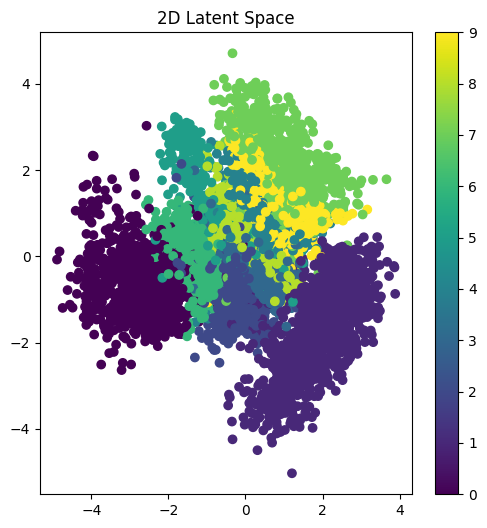

In [10]:
encoder_shared.eval()
encoder_mean.eval()
encoder_log_var.eval()
decoder.eval()

all_z = []
all_labels = []

with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(device)
        z_mean, _, _ = encode(data)
        all_z.append(z_mean.cpu().numpy())
        all_labels.append(labels.numpy())

x_test_encoded = np.concatenate(all_z, axis=0)
y_test = np.concatenate(all_labels, axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='viridis')
plt.colorbar()
plt.title("2D Latent Space")
plt.show()


## Last but not least, let's generate Figure 2.7.

The only tricky part here is that we have to create a grid over which we interpolate. Which we do by using `np.linspace`, which enables us to move between `min` and `max` value in `step_size`. 

We then just generate a digit for each sample in the for loop and display!

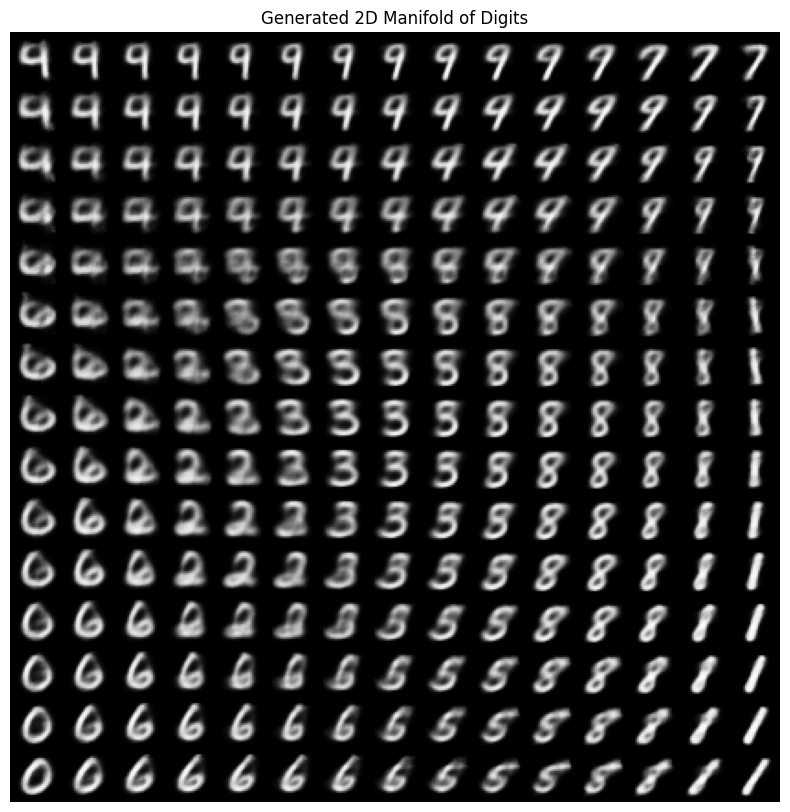

In [12]:
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Create grid coordinates by applying the inverse CDF (ppf) of the Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

decoder.eval()
with torch.no_grad():
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            # Directly use the decoder for a given latent coordinate
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            x_decoded = decoder(z_sample)
            digit = x_decoded.cpu().numpy().reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.title("Generated 2D Manifold of Digits")
plt.axis('off')
plt.show()
